# Config

In [1]:
import os

In [2]:
##### file system
INPUT_DIR = "/kaggle/input/audio-mnist/data"
WORKING_DIR = "/kaggle/working"

##### dataset
SAMPLE_RATE = 48_000
MAX_INPUT_SIZE = 65_536

##### training
TRAIN_PERCENTAGE = 0.8
BATCH_SIZE = 32
DATA_PERCENTAGE = 0.5

##### notebook
EXPLORING = False

In [3]:
if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)

# Explore Data

In [4]:
from tqdm import tqdm
from scipy.io import wavfile
import shutil
import matplotlib.pyplot as plt
import pandas as pd

## Prepare Data for PyTorch

I will be using PyTorch, to load a custom dataset it needs some fixing.

- I will create a csv file with information regarding all files

In [5]:
def create_csv_info():
    # initialize the dataset
    dataset = pd.DataFrame(columns=["file", "label", "speaker"])

    for speaker in tqdm(os.listdir(INPUT_DIR)):
        # check if "speaker" is a folder
        # "speaker" should be a folder with all the recordings from the given
        #   speaker, the name of the speaker is the name of the folder
        if not os.path.isdir(os.path.join(INPUT_DIR, speaker)):
            continue

        for file in os.listdir(os.path.join(INPUT_DIR, speaker)):
            label = file.split("_")[0]
            file_path = os.path.join(speaker, file)

            dataset = dataset.append({
                "file": file_path,
                "label": label,
                "speaker": speaker
            }, ignore_index=True)

    # write dataset as csv
    dataset.to_csv(os.path.join(WORKING_DIR, "dataset.csv"), index=False)

In [6]:
if not os.path.exists('/kaggle/working/dataset.csv'):
    create_csv_info()


100%|██████████| 61/61 [01:12<00:00,  1.19s/it]


# Load Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np


In [8]:
class AudioSample():
    # this defines one audio sample
    def __init__(self, sample_rate, samples):
        self.sample_rate = sample_rate
        self.samples = samples

    def display(self):
        plt.plot(self.samples)
        plt.show()


class AudioDescription():
    # apart from the audio also has the label and the speaker
    def __init__(self, audio_sample, label, speaker):
        self.audio_sample = audio_sample
        self.label = label
        self.speaker = speaker

    def display(self):
        self.audio_sample.display()
        print("Label: ", self.label)
        print("Speaker: ", self.speaker)


class AudioMNIST(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        csv_file_full_path = os.path.join(root_dir, csv_file)

        self.dataset = pd.read_csv(csv_file_full_path)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_path = os.path.join(self.root_dir, self.dataset.iloc[idx, 0])

        sample_rate, samples = wavfile.read(file_path)

        audio_description = AudioDescription(
            AudioSample(sample_rate, samples),
            self.dataset.iloc[idx, 1],
            self.dataset.iloc[idx, 2]
        )

        if self.transform:
            audio_description = self.transform(audio_description)

        return audio_description


## Transforms

The data in dataset does not have all the same size. So transformations are
required. Two transformations are possible. Padding and Cropping.

In [9]:
class Padding():
    def __init__(self, output_size=MAX_INPUT_SIZE, mode="edge"):
        # output size is an integer
        # for mode check np.pad https://numpy.org/doc/stable/reference/generated/numpy.pad.html
        self.output_size = output_size
        self.mode = mode

    def __call__(self, audio_description):
        # sample is an AudioDescription
        if len(audio_description.audio_sample.samples) > self.output_size:
            # throw error; cannot pad sample to a smaller size
            raise ValueError("Cannot pad sample to a smaller size")

        new_samples = np.pad(audio_description.audio_sample.samples, ((self.output_size - len(audio_description.audio_sample.samples) + 1) //
                                                                      2, (self.output_size - len(audio_description.audio_sample.samples)) // 2), mode=self.mode)

        return AudioDescription(
            AudioSample(audio_description.audio_sample.sample_rate, new_samples),
            audio_description.label,
            audio_description.speaker
        )


class RandomCrop():
    def __init__(self, output_size=int(MAX_INPUT_SIZE/2)):
        # output size is an integer
        self.output_size = output_size

    def __call__(self, audio_description):
        # audio_sample is an AudioDescription
        if len(audio_description.audio_sample.samples) <= self.output_size:
            # pad the sample
            audio_description = Padding(self.output_size)(audio_description)
        else:
            # get random start index
            start_index = np.random.randint(
                0, len(audio_description.audio_sample.samples) - self.output_size)

            audio_description = AudioDescription(AudioSample(
                audio_description.audio_sample.sample_rate, audio_description.audio_sample.samples[start_index:start_index + self.output_size]),
                audio_description.label,
                audio_description.speaker
            )

        return audio_description


## Putting it all together

In [10]:
dataset = AudioMNIST(WORKING_DIR + "/dataset.csv",
                     INPUT_DIR, transform=RandomCrop())

# split dataset into train and test
train_size = int(TRAIN_PERCENTAGE * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size])


def my_collate(batch):
    # batch is a list of AudioDescription
    samples = []
    labels = []
    speakers = []

    for audio_description in batch:
        samples.append(audio_description.audio_sample.samples)
        labels.append(audio_description.label)
        speakers.append(audio_description.speaker)

    # convert the list of audio samples to a tensor with shape [N, W]
    X = torch.tensor(samples)

    # add a new dimension to the tensor to get the desired shape [N, 1, W]
    X = X.unsqueeze(1)

    # convert the lists of labels and speakers to tensors
    y = torch.tensor(labels)
    z = torch.tensor(speakers)

    # return the modified tensors
    return X, y, z


dataloader_train = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=my_collate)
dataloader_test = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=my_collate)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
# show one sample with the loader
for sample, label, speaker in dataloader_train:
    print(f"Shape of X [N, C, W]: {sample.shape}")
    print(f"Shape of y: {label.shape} {label.dtype}")
    break
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

Shape of X [N, C, W]: torch.Size([32, 1, 32768])
Shape of y: torch.Size([32]) torch.int64


# Model

In [12]:
from torch import nn
import random
import time
import torch.nn.functional as F

In [13]:
# get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
class VAE(nn.Module):
    def __init__(self, convolutional_layers=2, input_size=int(MAX_INPUT_SIZE/2), latent_dim=10):
        super().__init__()

        if convolutional_layers < 1:
            raise ValueError("Convolutional layers must be at least 1")

        self.convolutional_layers = convolutional_layers
        self.latent_dim = latent_dim
        self.input_size = input_size

        self.encoder, self.meaner, self.varer = self._build_encoder()
        self.decoder = self._build_decoder()

    def forward(self, x):
        # float the input
        x = x.float()

        # pass it through the common part of the encoder
        y = self.encoder(x)

        # in a VAE, after the encoder, it splits into two branches
        # one with latent_dims of means, and other of vars
        mean = self.meaner(y)
        logvar = self.varer(y)

        # get a list from the mean and vars
        z = self._sample(mean, logvar)

        # take that list of latent values and decode it
        decoded = self.decoder(z)
        return decoded, mean, logvar

    def _build_encoder(self):
        layers = []

        layers.append(nn.Conv1d(1, 32, kernel_size=9, stride=1, padding=4))
        layers.append(nn.BatchNorm1d(32))
        layers.append(nn.Tanh())
        layers.append(nn.MaxPool1d(kernel_size=2, stride=2))

        for i in range(self.convolutional_layers - 1):
            # add a convolutional layer with 2^i filters, kernel size 9, stride 1, padding 'same'
            layer = nn.Conv1d(2**i*32, 2**(i+1)*32,
                              kernel_size=9, stride=1, padding=4)
            layers.append(layer)
            layers.append(nn.BatchNorm1d(2**(i+1)*32))
            # add a tanh activation function
            layers.append(nn.Tanh())

            # add a max pooling layer with kernel size 2 and stride 2
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))

        # output both the mean and log variance of the latent variables
        mean_layer = nn.Sequential(
            # global average pooling
            nn.AdaptiveAvgPool1d(1),
            # flatten the output
            nn.Flatten(),
            # add a linear layer with latent_dims outputs
            nn.Linear(2**(self.convolutional_layers-1)*32, self.latent_dim)
        )

        var_layer = nn.Sequential(
            # global average pooling
            nn.AdaptiveAvgPool1d(1),
            # flatten the output
            nn.Flatten(),
            # add a linear layer with latent_dims outputs
            nn.Linear(2**(self.convolutional_layers-1)*32, self.latent_dim)
        )

        return nn.Sequential(*layers), mean_layer, var_layer

    def _build_decoder(self):
        layers = []

        # the input is the latent vector
        # one should transform it to a tensor with shape
        # [N, 2^convolutional_layers*32, W/2^convolutional_layers]
        # where N is the batch size, W is the width of the original input
        layers.append(
            nn.Linear(self.latent_dim, 2**(self.convolutional_layers-1)
                      * 32 * (self.input_size // 2**self.convolutional_layers))
        )

        # reshape the tensor to [N, 2^convolutional_layers*32, W/2^convolutional_layers]
        layers.append(
            nn.Unflatten(1, (2**(self.convolutional_layers-1)*32,
                         self.input_size // 2**self.convolutional_layers))
        )

        # i decreasing from convolutional_layers to 0
        for i in range(self.convolutional_layers - 2, -1, -1):
            layers.append(nn.Upsample(scale_factor=2))
            layers.append(nn.ConvTranspose1d(2**(i+1)*32, 2**i *
                                             32, kernel_size=9, stride=1, padding=4))
            layers.append(nn.BatchNorm1d(2**i*32))
            layers.append(nn.Tanh())

        layers.append(nn.Upsample(scale_factor=2))
        layers.append(nn.ConvTranspose1d(
            32, 1, kernel_size=9, stride=1, padding=4))
        layers.append(nn.BatchNorm1d(1))
        layers.append(nn.Tanh())

        return nn.Sequential(*layers)

    def _sample(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean

    def loss_function(self, recon_x, x, mean, logvar):
        # VAE loss function
        # get max and min values
        recon_x = torch.clamp(recon_x, 0, 1) # normalize output
        x = torch.clamp(x, 0, 1) # normalize input
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        return BCE + KLD


# Training

In [15]:
def train_step(data_loader, model, optimizer):
    model.train()

    train_loss = 0

    for batch, (sample, label, _) in enumerate(data_loader):
        # normalize the audio wav sample
        sample = sample / 32768
        sample = sample.float()

        # send variables to GPU (if available)
        sample, label = sample.to(device), label.to(device)

        # compute prediction error
        recon_batch, mean, logvar = model(sample)
        loss = model.loss_function(recon_batch, sample, mean, logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(sample)
            print(
                f"loss: {loss:>7f}  [{current:>5d}/{len(data_loader.dataset):>5d}]")

        del sample, label

    train_loss /= len(data_loader.dataset)
    return train_loss


def test(data_loader, model, name):
    model.eval()

    test_loss = 0
    showed = False

    with torch.no_grad():
        for sample, label, _ in data_loader:
            # normalize the audio wav sample
            # passing to the realm of values between -1 and 1
            # or wav format 32-bit floating-point
            # check https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html
            sample = sample / 32768

            sample, label = sample.to(device), label.to(device)

            sample.float()

            pred, mean, logvar = model(sample)
            loss = model.loss_function(pred, sample, mean, logvar)
            
            test_loss += loss

            # show a random wave
            if not showed:
                showed = True
                sample = sample.cpu().detach().numpy()
                pred = pred.cpu().detach().numpy()

                # Create the first plot
                plt.figure()
                plt.plot(sample[0][0])
                plt.title('Original Sample')
                plt.legend(['Original'])
                plt.show()

                # Create the second plot
                plt.figure()
                plt.plot(pred[0][0])
                plt.title('Reconstructed Sample')
                plt.legend(['Reconstructed'])
                plt.show()

                # save the sound
                wavfile.write("test_sample_" + str(name) +
                              ".wav", SAMPLE_RATE, sample[0][0])
                wavfile.write("test_pred_" + str(name) +
                              ".wav", SAMPLE_RATE, pred[0][0])

    test_loss /= len(data_loader)

    return test_loss


In [16]:
# things function deletes variables only if they exist, ignoring the error
# it's useful when one wants to delete multiple variables without knowing if they exist or not
# this notebook does that to save GPU variables
def del_if_found(variable):
    try:
        del variable
    except:
        pass

if 'model' in globals():
    del model

## Model settings

In [17]:
# maximum number of iterations without improvement
MAX_ITERATIONS_WITHOUT_IMPROVEMENT = 5
# number of convolutional layers of the encoder
CONV_LAYERS = 8
# possible learning rate ranges
LR_RANGE = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
# number of latent dimensions (average + stds)
LATENT_DIM = 100

## Find the optimal learning rate with the learning rate test

In [18]:
# creates the model
model = VAE(convolutional_layers=CONV_LAYERS, latent_dim=LATENT_DIM).to(device)

# display information regarding the mode
print(f"Training with {CONV_LAYERS} convolutional layers")
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

if EXPLORING:
    # sets the adam optimizer with the first learning rate in the range
    optimizer = torch.optim.Adam(model.parameters(), lr=LR_RANGE[0])

    # initialize empty list to store losses for each learning rate
    losses = []

    # loop through each learning rate in the range
    for lr in LR_RANGE:
        # set the learning rate for the optimizer
        optimizer.param_groups[0]['lr'] = lr

        # train the model for 3 epochs using the current learning rate
        for i in range(3):
            # call the train function and pass in the train dataloader, model, optimizer, and number of epochs to train for
            train_step(dataloader_train, model, optimizer)

            # print a message indicating that the epoch has completed
            print(f"Epoch {i+1} completed")

        # test the model on the test dataset and store the loss in the losses list
        loss = test(dataloader_test, model, f"{CONV_LAYERS}_{lr}")
        losses.append(loss)

        # print a message indicating the learning rate and the corresponding loss
        print(f"====> Learning rate: {lr} Loss: {loss:.4f}")

Training with 8 convolutional layers
Number of parameters: 255124043


## Training actually

In [19]:
if EXPLORING:
    # plot the learning rate vs loss curve
    plt.plot(torch.tensor(LR_RANGE), torch.tensor(losses), label='Loss')
    plt.xscale('log')
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # get optimal learning rate
    opt_lr = lr_range[losses.index(min(losses))]
else:
    opt_lr = 0.01
    
# reset optimizer with optimal learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)

Epoch 0:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 687999.687500  [    0/24000]
loss: 59395681550336.000000  [ 3200/24000]
loss: 33084899732750336.000000  [ 6400/24000]
loss: 16423095946444800.000000  [ 9600/24000]
loss: 2990019450029681410048.000000  [12800/24000]
loss: 19450080768493101252608.000000  [16000/24000]
loss: 1271294853120.000000  [19200/24000]
loss: 15976493782398977179648.000000  [22400/24000]
====> Epoch: 0 Training loss: 1989368118205993512248824299520.0000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

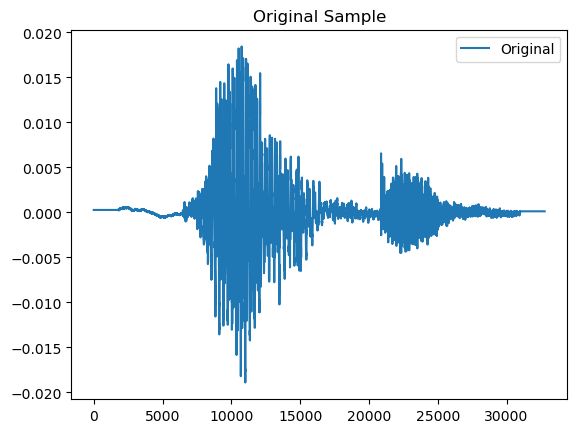

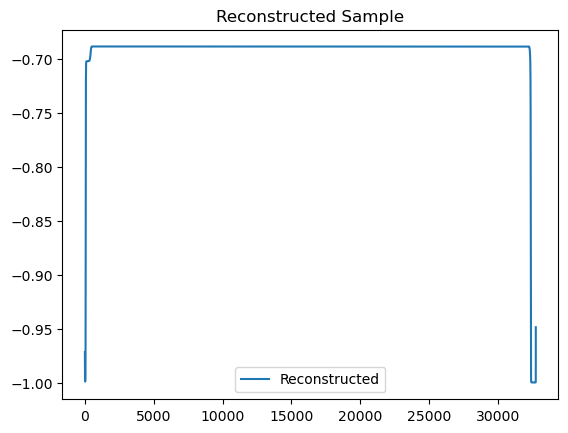

====> Test set loss: inf
Epoch 1:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 1336785603731363201024.000000  [    0/24000]


/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [15,0,0], thread: [96,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [15,0,0], thread: [97,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [15,0,0], thread: [98,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [15,0,0], thread: [99,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [15,0,0], thread: [100,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [15,0,0], thread: [101,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/usr/loc

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [20]:
# start training
start_time = time.time()
epoch = 0
iterations_without_improvement = 0
best_loss = float('inf')

while iterations_without_improvement < MAX_ITERATIONS_WITHOUT_IMPROVEMENT:
    print(f"Epoch {epoch}:")
    train_loss = train_step(dataloader_train, model, optimizer)
    print(f"====> Epoch: {epoch} Training loss: {train_loss:.4f}")
    loss = test(dataloader_test, model, f"{CONV_LAYERS}_{epoch}")
    print(f"====> Test set loss: {loss:.4f}")

    if loss < best_loss:
        best_loss = loss
        iterations_without_improvement = 0
        # save the model if it has improved
        torch.save(model.state_dict(), f"model_{CONV_LAYERS}.pth")
    else:
        iterations_without_improvement += 1

    epoch += 1

time_took = time.time() - start_time
print(f"Training time: {time_took} seconds")
print(f"Epochs: {epoch}")

print("Done!")

# del variables on gpu and skip if one of them is not found
del_if_found(model)
del_if_found(sample)
del_if_found(label)